In [2]:
import pandas as pd
weather_df = pd.read_csv('/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/data/weather_data_cleaned.csv')
crowd_df = pd.read_csv('/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/data/sensor_data.csv')
crowd_df['timestamp'] = pd.to_datetime(crowd_df['timestamp'], utc=False)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=False)
weather_df = weather_df.rename(columns={'datetime': 'timestamp'})
weather_df['timestamp'] = weather_df['timestamp'].dt.tz_localize(None)
crowd_df['timestamp'] = crowd_df['timestamp'].dt.tz_localize(None)

merged_df = pd.merge_asof(
    crowd_df,
    weather_df,
    on = 'timestamp',
    direction = 'nearest',
    tolerance = pd.Timedelta('60min')
)

merged_df.set_index('timestamp')
merged_df.head()
sensor_cols = merged_df.columns[1:-14]
feature_cols = merged_df.columns[-14:]

In [3]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import os 

X = merged_df[feature_cols]
y = merged_df[sensor_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

multi_xgb = MultiOutputRegressor(xgb.XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=6, objective='reg:squarederror', n_jobs=-1
))

multi_xgb.fit(X_train, y_train)
y_pred = multi_xgb.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R2-score: {r2}")


Mean Absolute Error: 15.612740516662598
R2-score: 0.27257198095321655


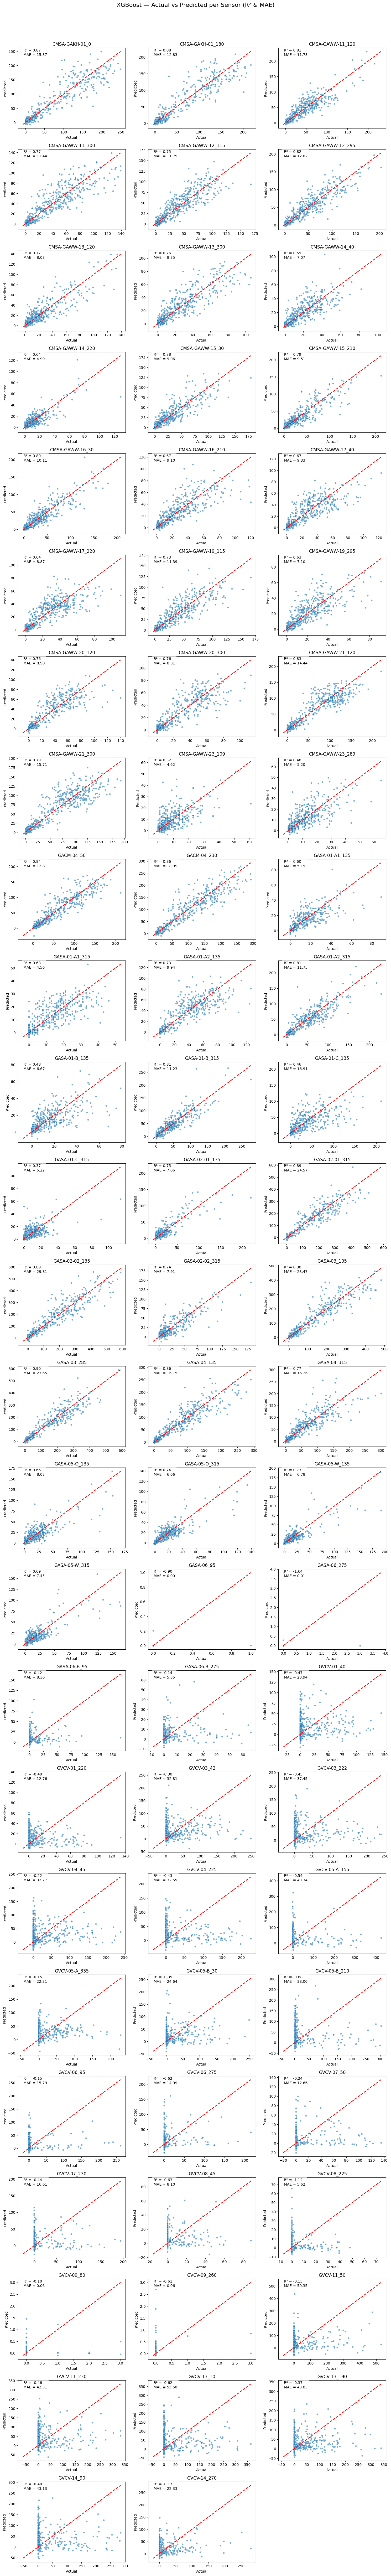

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# y_test is a DataFrame with sensor columns
# y_pred is a NumPy array (from multi-output model)

n_sensors = len(sensor_cols)
n_cols = 3  # number of columns in subplot grid
n_rows = int(np.ceil(n_sensors / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, sensor in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Actual vs Predicted
    x = y_test[sensor].values        # actual values
    y = y_pred[:, i]                 # predicted values
    
    sns.scatterplot(x=x, y=y, s=20, alpha=0.6)
    
    # 1:1 reference line
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    # Metrics
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    
    # Annotate metrics
    plt.text(
        0.05, 0.90,
        f"R² = {r2:.2f}\nMAE = {mae:.2f}",
        transform=plt.gca().transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )
    
    plt.title(sensor)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

plt.suptitle("XGBoost — Actual vs Predicted per Sensor (R² & MAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_34261/1937193539.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_34261/1937193539.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_34261/1937193539.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_34261/1937193539.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

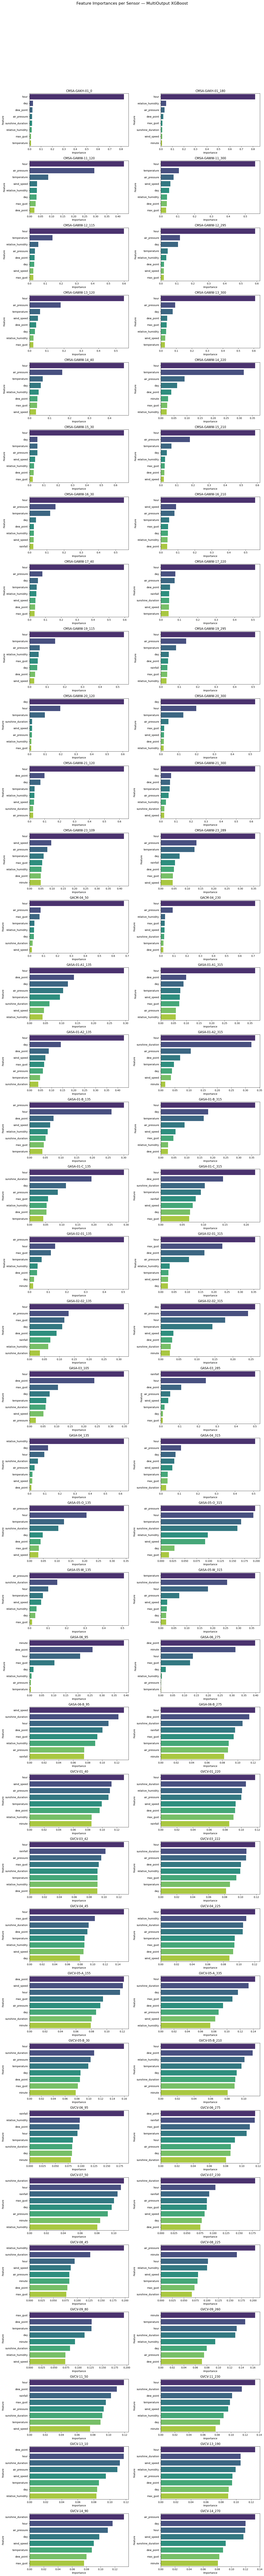

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

n_sensors = len(sensor_cols)
n_rows = int(np.ceil(n_sensors / 2))  # 2 columns
n_cols = 2

plt.figure(figsize=(15, n_rows*4))

for i, sensor in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Get the individual model for this sensor
    model = multi_xgb.estimators_[i]
    
    # Feature importances
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 8 features
    sns.barplot(
        data=importance_df.head(8),
        x='Importance', y='Feature',
        palette='viridis'
    )
    plt.title(sensor)

plt.suptitle("Feature Importances per Sensor — MultiOutput XGBoost", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


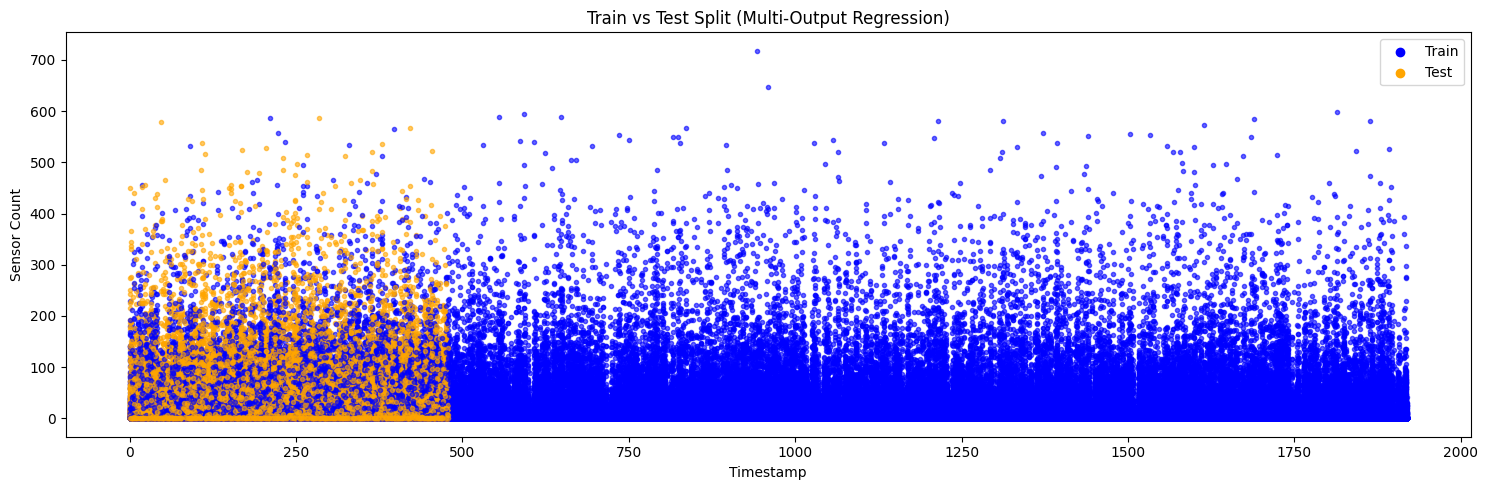

In [8]:
# Get original timestamps using indices
train_idx = merged_df.iloc[X_train[:,0].argsort()].index   # sorted ordering
test_idx = merged_df.iloc[X_test[:,0].argsort()].index

plt.figure(figsize=(15,5))

for sensor in sensor_cols:

    # TRAIN
    plt.plot(
        train_idx,
        y_train[sensor].values,
        '.',
        alpha=0.6,
        color='blue'
    )

    # TEST
    plt.plot(
        test_idx,
        y_test[sensor].values,
        '.',
        alpha=0.6,
        color='orange'
    )

plt.title("Train vs Test Split (Multi-Output Regression)")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Count")

plt.scatter([], [], color="blue", label="Train")
plt.scatter([], [], color="orange", label="Test")
plt.legend()
plt.tight_layout()
plt.show()


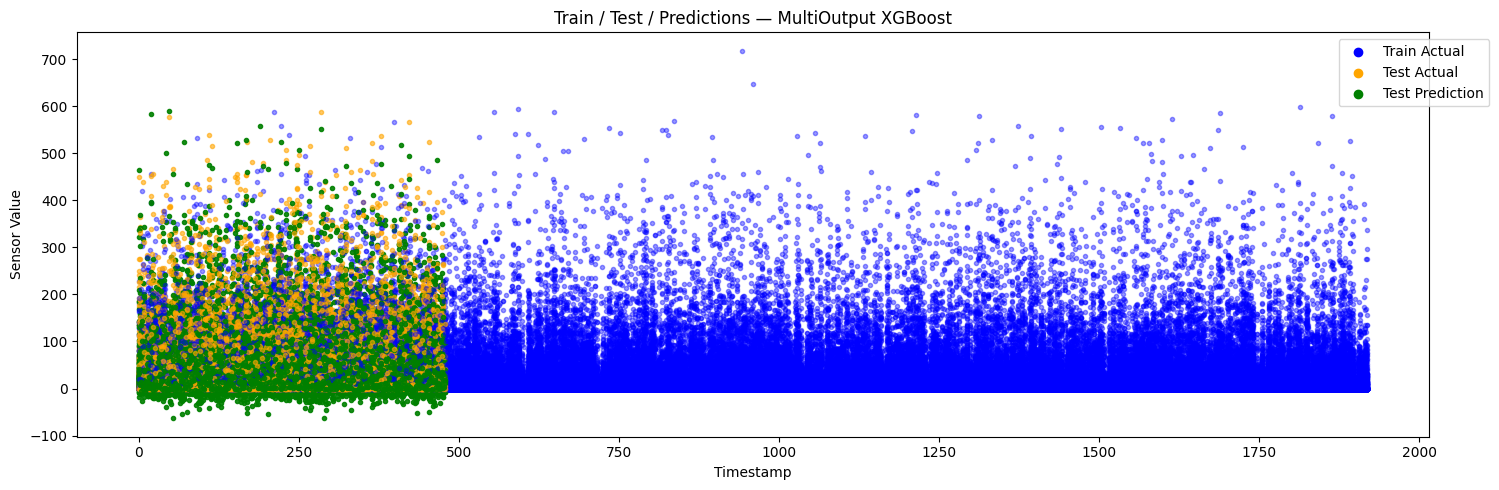

In [11]:
plt.figure(figsize=(15,5))

for i, sensor in enumerate(sensor_cols):

    # TRAIN actual
    plt.plot(
        train_idx,
        y_train[sensor].values,
        '.',
        color="blue",
        alpha=0.4
    )

    # TEST actual
    plt.plot(
        test_idx,
        y_test[sensor].values,
        '.',
        color="orange",
        alpha=0.6
    )

    # TEST prediction
    plt.plot(
        test_idx,
        y_pred[:, i],
        '.',
        linewidth=1.5,
        color="green",
        alpha=0.9
    )

plt.title("Train / Test / Predictions — MultiOutput XGBoost")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")

plt.scatter([], [], color='blue', label='Train Actual')
plt.scatter([], [], color='orange', label='Test Actual')
plt.scatter([], [], color='green', label='Test Prediction')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [12]:
per_sensor_results = []

for i, sensor in enumerate(sensor_cols):
    actual = y_test[sensor].values
    pred = y_pred[:, i]
    per_sensor_results.append((sensor,
                               r2_score(actual, pred),
                               mean_absolute_error(actual, pred)))

perf_df = pd.DataFrame(per_sensor_results, columns=["Sensor", "R2", "MAE"])
perf_df = perf_df.sort_values("R2", ascending=False)

best_sensor = perf_df.iloc[0]["Sensor"]
worst_sensor = perf_df.iloc[-1]["Sensor"]

print("Best sensor:", best_sensor)
print("Worst sensor:", worst_sensor)


Best sensor: GASA-03_285
Worst sensor: GASA-06_275


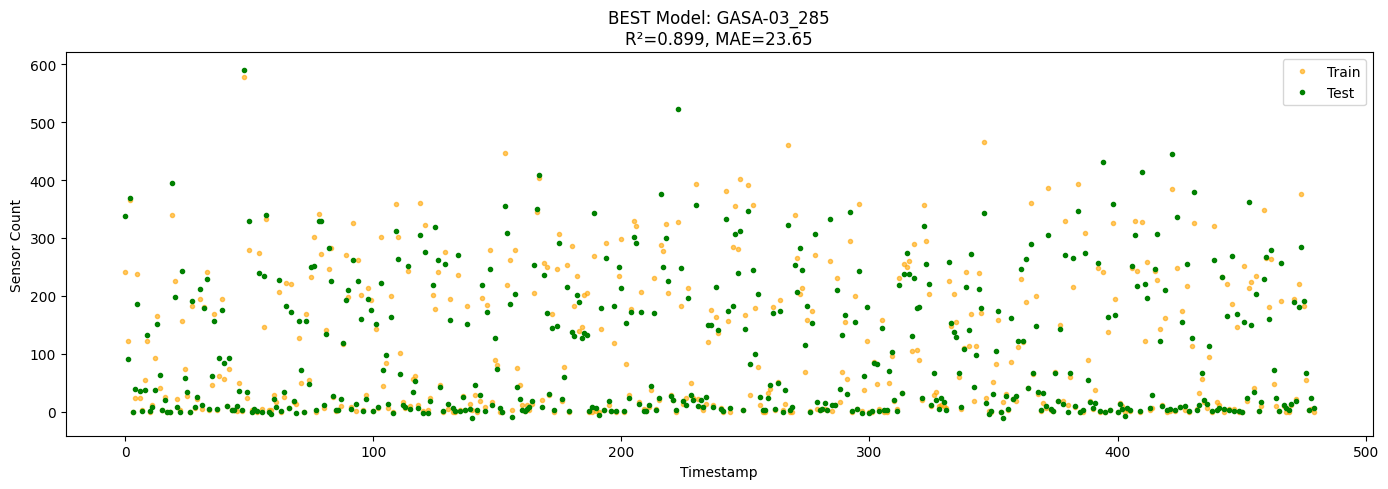

In [18]:
plt.figure(figsize=(14,5))

idx = sensor_cols.get_loc(best_sensor)

# plt.plot(train_idx, y_train[best_sensor], '.', color='blue', alpha=0.4)
plt.plot(test_idx, y_test[best_sensor], '.', color='orange', alpha=0.6)
plt.plot(test_idx, y_pred[:, idx], '.', color='green', linewidth=2)

plt.title(f"BEST Model: {best_sensor}\nR²={perf_df.iloc[0]['R2']:.3f}, MAE={perf_df.iloc[0]['MAE']:.2f}")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Count")
plt.legend(["Train", "Test", "Prediction"])
plt.tight_layout()
plt.show()


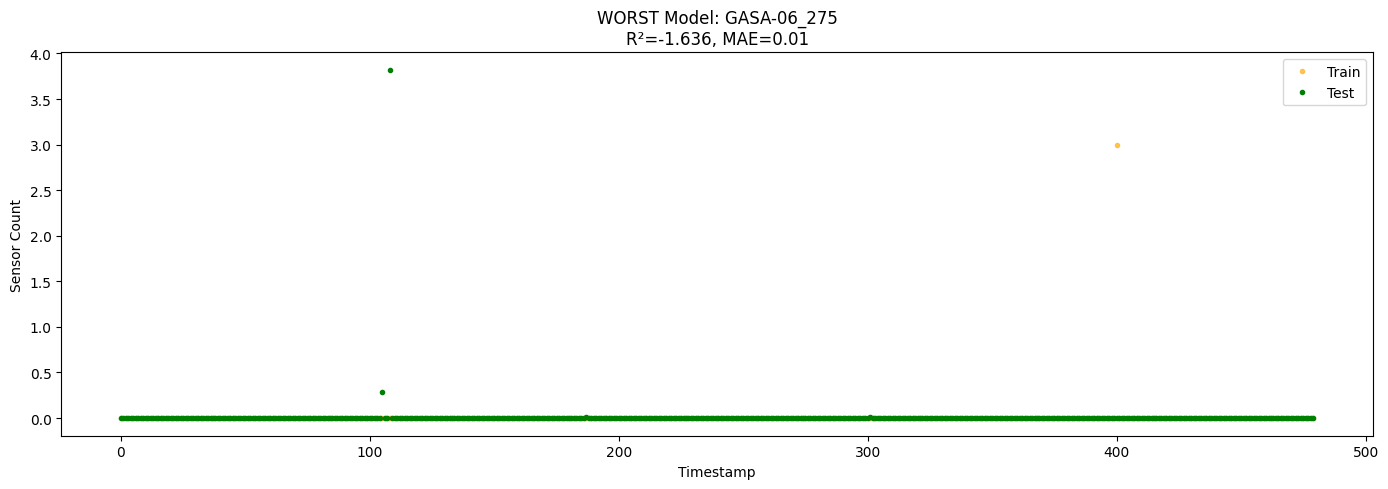

In [20]:
plt.figure(figsize=(14,5))

idx = sensor_cols.get_loc(worst_sensor)

# plt.plot(train_idx, y_train[worst_sensor], '.', color='blue', alpha=0.4)
plt.plot(test_idx, y_test[worst_sensor], '.', color='orange', alpha=0.6)
plt.plot(test_idx, y_pred[:, idx], '.', color='green', linewidth=2)

plt.title(f"WORST Model: {worst_sensor}\nR²={perf_df.iloc[-1]['R2']:.3f}, MAE={perf_df.iloc[-1]['MAE']:.2f}")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Count")
plt.legend(["Train", "Test", "Prediction"])
plt.tight_layout()
plt.show()
